# Sparse GP Classification

## Model Description

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_n \sim \mathrm{Bernoulli}(\sigma(f))$,

where $K(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}\mathrm{softplus}({\alpha_d})\cdot(x_{1d} - x_{2d})^2\right)$.
<br>
Here, latent process $f\sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$ is defined as:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$u=f_0\small{(z_{1:M})}$ for $f_0\sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f(x)\sim\mathcal{GP}(K| f\small{(z_{1:M})}=u)$ <br>
Additionally, conditional independence of process $f$ among any points given $u=f_0\small{(z_{1:M})} = \left(f_0(z_1), ..., f_0(z_M)\right)$ is assumed. <br>
That is, for any $n_1$ and $n_2$, $f(x_{n_1})\perp \!\!\! \perp f(x_{n_1})|u$.

## Local Marginalization of Evidece Lower Bound
By simplifying notation as $f_{1:N} = f(x_{1:N})$ and $u = f(z_{1:M})$, we can write evidence lower bound (ELBO) and locally margianlized likelihood (LM-ELBO).

\begin{align}
\mathrm{LM}\text{-}\mathrm{ELBO}
&= \log p(y_{1:N}) - \mathrm{KL}\left[\ q(u)\ ||\ p(u|y_{1:N})\ \right] \\
&= \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&\geq \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)
- \mathrm{KL}\left[\ p(f_{1:N}|u)\ ||\ p(f_{1:N}| y_{1:N}, u)\ \right]\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \log p(y_{1:N}) - \mathrm{KL}\left[ p(f_{1:N}|u)q(u) || p(y_{1:N}, f_{1:N}, u) \right]\\
&= \mathrm{E}_{u\sim q} \mathrm{E}_{f_{1:N}\sim p(f_{1:N}|u)}\left[
\log \left(\frac{p(y_{1:N}, f_{1:N}, u)}{p(f_{1:N}| u)q(u)}\right) 
\right] \\
&= \sum_{n=1}^N\mathrm{E}_{u\sim q} \mathrm{E}_{f_n\sim p(f_n|u)}
\left[ \log p(y_n| f_n) \right] 
- \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \mathrm{ELBO}
\end{align}

### Possible Datasets
- http://archive.ics.uci.edu/ml/datasets/Adult
- http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking
- http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
- http://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+

## Import Packages

In [144]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [145]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
import matplotlib
from matplotlib import pyplot as plt
import time
import datetime
np.random.seed(0)

In [146]:
tf.test.is_gpu_available()

False

## Utilities

In [147]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Generate Toy Dataset

In [224]:
N = 1000
D = 2

In [149]:
# Paramters
b0 = np.float64(0.)
b  = np.random.randn(D) / np.sqrt(D)

In [150]:
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, b0, b):
    """
    Genarate N samples of data from the model with parameter [beta0, beta, alpha]. 
    Returns:
    x: 3-d array of size [N, D]
    y: 2-d array of size [N]
    """
    x = np.random.randn(N*D).reshape([N,D])
    logit = lambda x: b0+x@b
    y = bernoulli(p=sigmoid(logit(x))).rvs()
    likelihood = np.sum(y*np.log(sigmoid(logit(x))) + (1-y)*np.log(1-sigmoid(logit(x))))
    print('test_likelihood: {}'.format( likelihood ) )
    return x,y, logit

In [151]:
x,y,logit = generate_data(N, D, b0, b)

test_likelihood: -560.6633839821673


In [225]:
M = 30
theta = {
    'z': tf.Variable(2.*np.random.randn(M*D).reshape([M,D])),
    'alpha': tf.Variable(np.ones([D]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64)
}
phi = {
    'm': tf.Variable(np.zeros([M]), dtype=tf.float64),
    'S': tf.Variable(np.eye(M), dtype=tf.float64)
}

In [153]:
def get_K(alpha, beta):
    # define Kernel
    D = alpha.shape[0]
    sp_alpha = tf.reshape( tf.math.softplus( alpha ), [1,1,D])
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, 2])
        x2 = tf.reshape(x2, [1 ,n2, 2])
        return tf.exp(beta - tf.reduce_sum( sp_alpha*(x1-x2)**2, axis=2))
    return K

## ELBO

In [154]:
def ELBO(x, y, theta, phi, N_total):
    '''
    Inputs:
    x: 2-d array of shape [N,D]
    y: 1-d array of shape [N]
    theta: disctionary of model parameters
    phi: disctionary of variational parameters
    
    Returns:
    elbo: scalar
    '''
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample()

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    elbo = tf.reduce_mean(p_y.log_prob(y)) - kl_qu_pu / N_total
    return elbo

In [170]:
def LMELBO(x, y, theta, phi, N_total, n_MC):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample(n_MC)

    # compute LMELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    log_prob_y = tf.reduce_mean( tf_logmeanexp( p_y.log_prob(y) , axis=0) ) 
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    lmelbo = log_prob_y - kl_qu_pu / N_total
    return lmelbo

In [156]:
def pointwise_dconditional_likelihood(x, y, theta, phi, level):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    if level==0:
        return tf_logmeanexp(w, axis=0) 
    else:
        return tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)

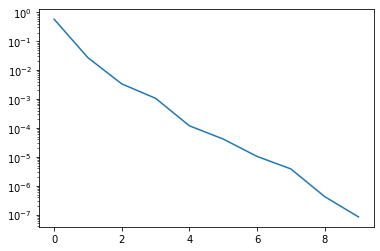

In [206]:
get_var = lambda l: pointwise_dconditional_likelihood(x, y, theta, phi, level=l).numpy().var()
plt.plot([get_var(l) for l in range(10)])
plt.yscale('log')

In [158]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=1).numpy().var()

0.03126870259468976

In [159]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=2).numpy().var()

0.0041383015103111515

In [160]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=3).numpy().var()

0.0013936474982571894

In [161]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=4).numpy().var()

0.00012949616413605766

In [162]:
def dconditional_likelihood(x, y, mean_f, var_f, level):
    
    N = y.shape[0]
    # sample f_n's
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)
    
    # sample conditional likelihoods
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    
    if level==0:
        dL = tf_logmeanexp(w, axis=0) 
    else:
        dL = tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)
    return tf.reduce_mean( dL )

In [163]:
def LMELBO_MLMC(x, y, theta, phi, N_total, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    # unpack parameters
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # calculate KL divergence of p(u) and q(u) of u = f_0(z_1,...,z_M)
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
      
    # calculate distribution of f conditionally on u = f_0(z_1,...,z_M)
    u = q_u.sample(N)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    # determine proportions of the number of smaples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    lmelbo = kl_qu_pu / N_total
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mean_f_tmp = mean_f[offset:offset+Ns[i]]
        var_f_tmp = var_f[offset:offset+Ns[i]]
                       
        if randomize==True:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l)
    
        offset += Ns[i]
          
    return lmelbo

In [164]:
ELBO(x, y, theta, phi, 10000)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.901020819650497>

In [221]:
LMELBO(x, y, theta, phi, 10000, n_MC=2**10)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8438692044035605>

In [218]:
LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10, w0=1-2.**(-3/2), b=2, randomize=False)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8029116955270268>

## Parameter Estimation

In [245]:
def apply_grad(param, dparam, learning_rate):
    for p, dp in zip(param.values(), dparam.values()):
        p.assign_add(- learning_rate * dp)

In [260]:
def phi_to_eta(phi):
    return {
        'm': phi['m'],
        'S': tf.einsum('i,j->ij', phi['m'], phi['m']) + phi['S']
    }
def eta_to_phi(eta):
    return {
        'm': eta['m'],
        'S': eta['S'] - tf.einsum('i,j->ij', eta['m'], eta['m'])
    }
def deta_to_dphi(deta, phi):
    m = phi['m']
    S = phi['S']
    deta_m = deta['m']
    deta_S = deta['S']
    return {
        'm': tf.einsum('ni,i->n',S,deta_m),
        'S': S@deta_S@S
    }

In [280]:
M = 30
theta = {
    'z': tf.Variable(2.*np.random.randn(M*D).reshape([M,D])),
    'alpha': tf.Variable(np.ones([D]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64)
}
phi = {
    'm': tf.Variable(np.zeros([M]), dtype=tf.float64),
    'S': tf.Variable(np.eye(M), dtype=tf.float64)
}

In [265]:
for t in range(1000):
    rho_t = 10/(10+t)**0.7
    
    with tf.GradientTape() as g:
        eta = phi_to_eta(phi)
        g.watch([theta, eta])
        phi_tmp = eta_to_phi(eta)
        loss = - LMELBO(x, y, theta, phi_tmp, 1000, n_MC=10)
    dtheta, deta = g.gradient(loss, [theta, eta])
    dphi = deta_to_dphi(deta, phi)
    
    apply_grad(theta, dtheta, rho_t)
    apply_grad(phi, dphi, rho_t)
    
    if t%20==0:
        print('#iter: {}\t{}'.format(t, loss.numpy()))

#iter: 0	0.8027530159095813
#iter: 20	0.7209600389083066
#iter: 40	0.7032267542227282
#iter: 60	0.6714150648318016
#iter: 80	0.6680141767317862
#iter: 100	0.668125721379953
#iter: 120	0.6794591494062677
#iter: 140	0.6496476786171256
#iter: 160	0.6393760285648181
#iter: 180	0.647484061682403
#iter: 200	0.6454034829354133
#iter: 220	0.6403708484489458
#iter: 240	0.6353481453455491
#iter: 260	0.6329886468985767
#iter: 280	0.6556987677658255
#iter: 300	0.6340557230952818
#iter: 320	0.6308240106559245
#iter: 340	0.6160042958626935
#iter: 360	0.6191953296255317
#iter: 380	0.6266550595930078
#iter: 400	0.6214924248729439
#iter: 420	0.6450795147875993
#iter: 440	0.6175456457044403
#iter: 460	0.6307120024369601
#iter: 480	0.6200088954853369
#iter: 500	0.6240060344183631
#iter: 520	0.6334331399063401
#iter: 540	0.6296459262889758
#iter: 560	0.6338507978210729
#iter: 580	0.6228094272148483
#iter: 600	0.6238072385976351
#iter: 620	0.6174536083040771
#iter: 640	0.6273840109403475
#iter: 660	0.61759

In [278]:
def _LMELBO(x, y, theta, phi, N_total, n_MC):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    #S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = phi['S']#tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample(n_MC)

    # compute LMELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    log_prob_y = tf.reduce_mean( tf_logmeanexp( p_y.log_prob(y) , axis=0) ) 
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    lmelbo = log_prob_y - kl_qu_pu / N_total
    return lmelbo

In [281]:
optimizer = tf.keras.optimizers.RMSprop()

for t in range(1000):
    rho_t = 10/(10+t)**0.7
    
    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - _LMELBO(x, y, theta, phi, 1000, n_MC=10)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    if t%20==0:
        print('#iter: {}\t{}'.format(t, loss.numpy()))

#iter: 0	1.1202535375372762
#iter: 20	0.9467226748660393
#iter: 40	0.8604189114842937
#iter: 60	0.8380149457627317
#iter: 80	0.8213184355826852
#iter: 100	0.7676037667433054
#iter: 120	0.7663816292127975
#iter: 140	0.7541216055397393
#iter: 160	0.7445486292518756
#iter: 180	0.7313825794959726
#iter: 200	0.7359174879002544
#iter: 220	0.7167685470697222
#iter: 240	0.7217002198907755
#iter: 260	0.7198964257580126
#iter: 280	0.700759582104136
#iter: 300	0.7138522473924258
#iter: 320	0.6972961269768932
#iter: 340	0.6922164458570197
#iter: 360	0.6945976445822137
#iter: 380	0.687820592091976
#iter: 400	0.6875831843512047
#iter: 420	0.6697940786405593
#iter: 440	0.6738924211800924
#iter: 460	0.6939034725633315
#iter: 480	0.6618031235585022
#iter: 500	0.6522001771649084
#iter: 520	0.6585466037296563
#iter: 540	0.6444379220525908
#iter: 560	0.635730419515515
#iter: 580	0.6570175958469777
#iter: 600	0.6407195917817438
#iter: 620	0.6409770635940508
#iter: 640	0.6379251846021907
#iter: 660	0.615237

In [277]:
np.linalg.eigvalsh(phi['S'].numpy())

array([-0.00973479,  0.08207746,  0.1575643 ,  0.31365348,  0.37259114,
        0.47138114,  0.56190319,  0.60978471,  0.63316195,  0.70813019,
        0.77591913,  0.82633881,  0.83827905,  0.89600121,  0.94312201,
        0.9633664 ,  0.99759277,  1.02712709,  1.0587228 ,  1.07388804,
        1.14069172,  1.17195223,  1.23402027,  1.35345627,  1.39983421,
        1.49741377,  1.52221435,  1.62948601,  1.6648395 ,  1.71354758])

## Visualize Prediction

In [241]:
def get_logits(x, theta, phi):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    m = phi['m']
    S = phi['S']
    CholS = tf.linalg.cholesky(S)
    
    N = x.shape[0]
    M = z.shape[0]
    
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,j->n', K_nm, inv_K_mm, m)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    return mean_f, var_f

In [242]:
x1_heat = (np.linspace(start=-4,stop=4).reshape([1,50])*np.ones([50,1])).reshape([2500])
x2_heat = np.repeat(np.linspace(start=-4,stop=4), 50)
x_heat = np.array([x1_heat, x2_heat]).T
logits_heat = get_logits(x_heat, theta, phi)[0].numpy()

In [243]:
def heatmap2d(arr: np.ndarray, cmap='viridis'):
    plt.imshow(arr, cmap=cmap, extent=[-4,4,-4,4],origin='lower', alpha=1, vmin=0, vmax=1)
    plt.colorbar()
    #plt.show()

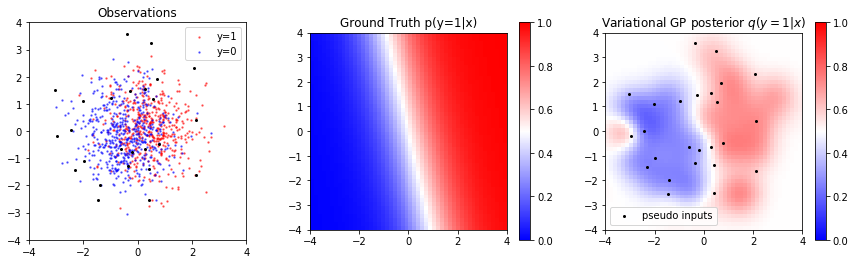

In [284]:
plt.figure(figsize=[15,4])
cmap = matplotlib.cm.get_cmap('bwr')#('viridis')

plt.subplot(1,3,1)
plt.title('Observations')
idx = (y==True)
plt.scatter(x[idx,0], x[idx,1], s=2, alpha=0.5, marker='o', c=[cmap(1.)])
plt.scatter(x[~idx,0], x[~idx,1], s=2, alpha=0.5, marker='o', c=[cmap(0.)])
plt.scatter(theta['z'][:,0], theta['z'][:,1], s=4, alpha=1, marker='o', c='black')
plt.legend(['y=1','y=0'])
plt.xlim([-4,4])
plt.ylim([-4,4])
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(1,3,2)
plt.title('Ground Truth p(y=1|x)')
heatmap2d(sigmoid(logit(x_heat)).reshape([50,50]), 'bwr')

plt.subplot(1,3,3)
plt.title(r'Variational GP posterior $q(y=1|x)$')
#plt.scatter(x[idx,0], x[idx,1], s=0.3, alpha=1, marker='x', c=[cmap(1.)])
#plt.scatter(x[~idx,0], x[~idx,1], s=0.3, alpha=1, marker='x', c=[cmap(0.)])
a = plt.scatter(theta['z'][:,0], theta['z'][:,1], s=4, alpha=1, marker='o', c='black')
plt.legend([a],['pseudo inputs'])
heatmap2d(sigmoid(logits_heat.reshape([50,50])), 'bwr')

## IW-ELBO approximation of Evidence

Importance weighted evidence lower bound (IW-ELBO) is an approximation of the evidence, and its Monte Carlo estimator is defined as:
$$\mathrm{IW}\text{-}\mathrm{ELBO}(x,z_{1:K}):=\frac{1}{N}\sum_{n=1}^{N}\log \frac{1}{K}\sum_{k=1}^{K}\left(\frac{p(x_n,z_{nk})}{q(z_{nk};x_n)}\right),$$
where $z_{nk}$ is sampled as $z_{nk}\sim q(z;x_n)$.

## Learning Curve by Different Methods

In [ ]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [ ]:
objectives = {
    "elbo":      lambda x, y, theta, phi: ELBO(x, y, theta, phi, N_total),
    "lmelbo8":   lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total, n_MC=8),
    "lmelbo64":  lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total, n_MC=64),
    "lmelbo512": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total, n_MC=512),
    "lmelbo512_mlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total, n_MC=512),
    "lmelbo512_randmlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total, n_MC),
}
N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)

n_repeat = 10
params_repeated = {name:[] for name in objectives.keys()}

for name, obj in objectives.items():
    alpha_s = []
    beta0_s = []
    beta_s = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))

        beta0_ = tf.Variable(0., dtype=tf.float64)
        beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
        alpha_   = tf.Variable(1., dtype=tf.float64)

        # Gradient Descent
        for t in range(2001):

            rho_t = 0.5/(1+t)**0.7
            x,y,_ = generate_data(N, D, T, beta0, beta, alpha)
            # balance the cost of mlmc and nmc when level=9 (n_MC=512)
            if 'mlmc' in name:
                cost_nmc  = N * 2**9
                cost_mlmc = get_mlmc_cost(N, max_level=9, b=1.8, w0=0.9)
                N_mlmc = np.math.ceil(N * (cost_nmc / cost_mlmc))
                x,y,_ = generate_data(N_mlmc, D, T, beta0, beta, alpha)    

            with tf.GradientTape() as g:
                g.watch([beta0_, beta_, alpha_])
                mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), alpha_.numpy())
                score = obj(x, y, beta0_, beta_, alpha_, mu, sigma)
            dbeta0_, dbeta_, dalpha_ = g.gradient(score, [beta0_, beta_, alpha_])

            beta0_ = beta0_ + rho_t*dbeta0_
            beta_ = beta_ + rho_t*dbeta_
            alpha_ = alpha_ + dalpha_
            if t%200==0 and i==0:
                print("#iter: {},\tloss: {}".format(t, -score.numpy()))
        alpha_s.append(alpha_.numpy())
        beta0_s.append(beta0_.numpy())
        beta_s.append(beta_.numpy())
    print()
    params_repeated[name] = {
            'alpha': np.array(alpha_s),
            'beta0': np.array(beta0_s),
            'beta': np.array(beta_s)
    }

#### Bottom Line: 
- IWELBO with large number of inner MC samples gives better estiamte than ELBO or sigmoid normal integral approximation, even for this simple model. 
- MLMC is more effective than nested MC when used for maximum likelihood estimation.